In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

sys.path.append("/app")
from visualizations.scripts.drawer import metric_viewer, russia_plots, russia_plots_n
from scripts.processing import read_table_gauge_str

gpd.options.io_engine = "pyogrio"

warnings.simplefilter(action="ignore", category=FutureWarning)

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

### Read necessary geometry

In [3]:
gauges_file = gpd.read_file("../geo_data/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")
ws_file = gpd.read_file("../geo_data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
ws_file = ws_file[ws_file["new_area"] <= 50000]


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "а) < 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "б) 100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "в) 2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "г) 10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"


ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "а) < 100 $км^2$",
        "б) 100 $км^2$ - 2 000 $км^2$",
        "в) 2 000 $км^2$ - 10 000 $км^2$",
        "г) 10 000 $км^2$ - 50 000 $км^2$",
    ],
)

basemap_data = gpd.read_file("../geo_data/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../geo_data/geometry/basin_districts.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.drop([26, 27])
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})

### Use only gauges from LSTM model

In [4]:
reasonable_gauges = pd.read_csv('./tables/LSTM_static_res.csv')
reasonable_gauges = reasonable_gauges["gauge_id"].astype(str).values
reasonable_gauges = [i for i in reasonable_gauges if i in ws_file.index]

ws_file = ws_file.loc[reasonable_gauges, :]
gauges_file = gauges_file.loc[reasonable_gauges, :]
gauges_file['size'] = np.NaN
gauges_file = gauges_file.combine_first(ws_file)
gauges_file = gauges_file.set_crs(epsg=4326)

### Area plot distribution

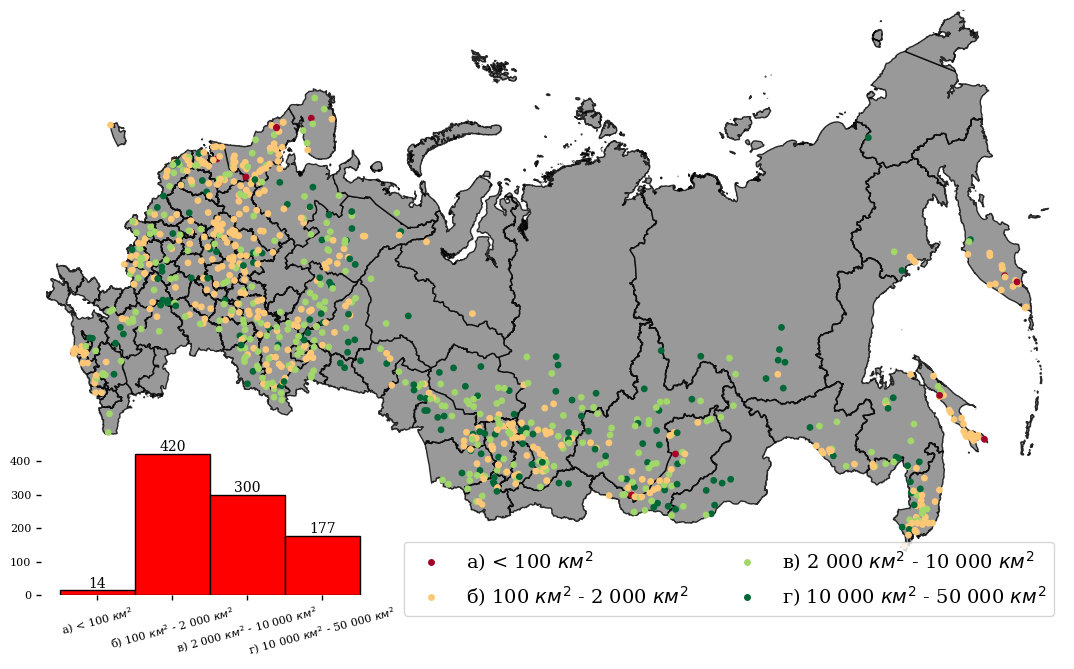

In [5]:
gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="size",
    # cmap_name='tab20',
    #   metric_col='Кластер',
    # list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    with_histogram=True,
)

### Geo-clusters

### Hydro-clusters